## Redo the model vis
* 2023-06-13
* test with CropLand Image model

In [132]:
import os
# set log level should be before import tf
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["AUTOGRAPH_VERBOSITY"] = "0"

import cv2
import sys
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

# import json
# import errno
# import seaborn as sns

# from tqdm import tqdm
# from cycler import cycler
# from datetime import datetime

# # albumentations
# from functools import partial
# import albumentations as A

# # RandAugment, AutoAugment, augment.py from TF github's augment.py
# from augment import RandAugment,AutoAugment


# from pytictoc import TicToc


# # custom leaf tk #
# from LeafTK import build_efn_model, WarmUpCosine, CosineDecayCLRWarmUpLSW, PrintLR, count_model_trainOrNot_layers
# # custom leaf tk new tf hub #
# from LeafTK import build_tf_hub_models, tf_hub_dict

In [173]:
img_size = 768

### Reload trained model

In [133]:
trained_model_pth = '/home/u3148947/tf.ds.pipeline/CropLandClassify/imagenet_resize_768x768_plateau_RA_bs128/EfficientNetV2B3_ep40_lr1e-4_acc9944/4'

In [134]:
best_model_reload = tf.keras.models.load_model(trained_model_pth)

In [178]:
best_model_reload.summary(expand_nested=True, show_trainable=True)

Model: "EfficientNetV2B3"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_first (InputLayer)    [(None, 768, 768, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 768, 768, 3)       0         Y          
                                                                            
 EfficientNetV2B3 (KerasLaye  (None, 1536)             12930622  Y          
 r)                                                                         
                                                                            
 top_output (Dense)          (None, 14)                21518     Y          
                                                                            
Total params: 12,952,140
Trainable params: 12,842,924
Non-trainable params: 109,216
___________________________________________

In [192]:
# display(best_model_reload.build_graph().summary())  #AttributeError: 'Functional' object has no attribute 'build_graph'
display(best_model_reload.summary())  #AttributeError: 'Functional' object has no attribute 'build_graph'

Model: "EfficientNetV2B3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_first (InputLayer)    [(None, 768, 768, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 768, 768, 3)       0         
                                                                 
 EfficientNetV2B3 (KerasLaye  (None, 1536)             12930622  
 r)                                                              
                                                                 
 top_output (Dense)          (None, 14)                21518     
                                                                 
Total params: 12,952,140
Trainable params: 12,842,924
Non-trainable params: 109,216
_________________________________________________________________


None

In [136]:
best_model_reload.get_metrics_result()

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}

In [160]:
best_model_reload

In [137]:
# best_model_reload.get_compile_config() #AttributeError: 'Functional' object has no attribute 'get_compile_config'

### Test image

    banana	  carrot  dragonfruit  guava   pineapple  rice	   sugarcane
bareland  corn	  garlic       peanut  pumpkin	  soybean  tomato

In [138]:
CLASSES = ['banana',
         'bareland',
         'carrot',
         'corn',
         'dragonfruit',
         'garlic',
         'guava',
         'peanut',
         'pineapple',
         'pumpkin',
         'rice',
         'soybean',
         'sugarcane',
         'tomato']
         
LABELS = {0: 'banana',
         1: 'bareland',
         2: 'carrot',
         3: 'corn',
         4: 'dragonfruit',
         5: 'garlic',
         6: 'guava',
         7: 'peanut',
         8: 'pineapple',
         9: 'pumpkin',
         10: 'rice',
         11: 'soybean',
         12: 'sugarcane',
         13: 'tomato'}

In [139]:
!ls "/home/u3148947/data/CropLandImage/img_800x/carrot/"

160106-3-0496.JPG  161209-1-0516.JPG	20171109-2-0304.JPG
160106-3-0510.JPG  161209-1-0518.JPG	20171109-2-0307.JPG
160106-3-0511.JPG  161209-1-0519.JPG	20171109-2-0310.JPG
160108-4-0036.JPG  161209-1-0520.JPG	20171109-2-0315.JPG
160108-4-0099.JPG  161209-1-0521.JPG	20171109-2-0325.JPG
160108-4-0295.JPG  161209-1-0524.JPG	20171109-2-0335.JPG
160108-4-0309.JPG  161209-1-0530.JPG	20171109-2-0336.JPG
160109-3-0003.JPG  161209-1-0536.JPG	20171109-2-0363.JPG
160109-3-0012.JPG  161209-1-0537.JPG	20171109-2-0371.JPG
160109-3-0013.JPG  161209-1-0538.JPG	20171109-2-0392.JPG
160109-3-0018.JPG  161209-1-0539.JPG	20171109-2-0394.JPG
160109-3-0031.JPG  161209-1-0540.JPG	20171109-2-0396.JPG
160109-3-0032.JPG  161209-1-0541.JPG	20171109-2-0402.JPG
160109-3-0045.JPG  161209-1-0542.JPG	20171109-2-0408.JPG
160109-3-0051.JPG  161209-1-0543.JPG	20171109-2-0409.JPG
160109-3-0053.JPG  161209-1-0544.JPG	20171109-2-0414.JPG
160109-3-0057.JPG  161209-1-0545.JPG	20171109-2-0415.JPG
160109-3-0060.JPG  161209-1-054

In [140]:
def get_bHWC_image(file_path, img_size=768, channels=3):
    """This CropLand tain with int8 dtype not the [0,1] rescaling dtype!!"""
    #from tensorflow.keras.layers import Rescaling
    
    # read image from path
    img = tf.io.read_file(file_path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels) # channels=3, channels=1 for gray Cleaned_GT training
    
    #img = Rescaling(scale=1./255, offset=0.0)(img)
    
    img = tf.image.resize(img, [img_size, img_size])
    img = tf.expand_dims(img, axis=0)
    return img

def plot_rgb_img_15(img):
    plt.figure(figsize=(6,6))
    plt.imshow(img) #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [141]:
test_img_pth ='/home/u3148947/data/CropLandImage/img_800x/banana/20170927-3-0434.JPG'
# test_img_pth ='/home/u3148947/data/CropLandImage/img_800x/bareland/20170123-2-1149.JPG'
# test_img_pth ='/home/u3148947/data/CropLandImage/img_800x/carrot/20171109-2-0304.JPG'
# test_img_pth ='/home/u3148947/data/CropLandImage/img_800x/corn/20170221-4-0090.JPG'
img = get_bHWC_image(test_img_pth)

In [142]:
img.shape

TensorShape([1, 768, 768, 3])

In [143]:
img.dtype

tf.float32

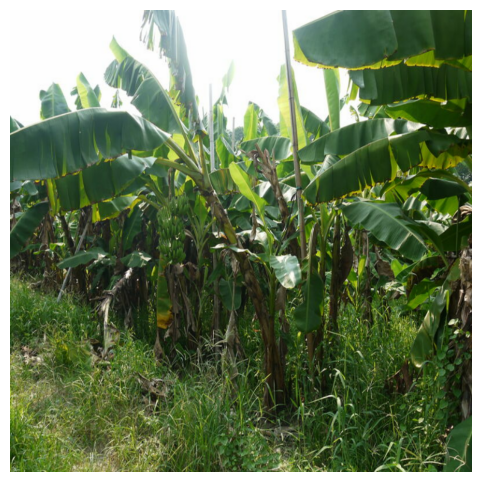

In [144]:
plot_rgb_img_15(np.array(img[0], np.uint8))

### Prediction

In [145]:
predictions = best_model_reload.predict(img)

1/1 [==============================] - 3s 3s/step


In [146]:
predictions

array([[1.0000000e+00, 4.1460577e-10, 1.7187101e-12, 7.9001552e-09,
        2.4541302e-10, 3.7839457e-10, 3.3880987e-10, 1.4514729e-09,
        1.1586744e-10, 1.2342456e-09, 3.9927270e-10, 3.9357770e-10,
        2.6095745e-10, 3.4175565e-11]], dtype=float32)

In [147]:
np.argmax(predictions)

0

In [148]:
# check predictions
print(f'\n predictions np shape : {np.shape(predictions)}')

# mean the k-predictions
k_predictions = np.mean(predictions, axis=0)
print(f'\n k_predictions(mean) np shape : {np.shape(k_predictions)}')


 predictions np shape : (1, 14)

 k_predictions(mean) np shape : (14,)


In [149]:
test_pred_int = np.argmax(k_predictions , axis=-1)
print(f'\n test_pred_int (argmax) np shape : {np.shape(test_pred_int)}')
print(f'test_pred_int[:10] : {test_pred_int}')

# test_pred_label = [ LABELS[pred_int] for pred_int in test_pred_int ]
# test_pred_label = np.expand_dims(test_pred_label, axis=1)  # #(10,) --> (10, 1)
# print(f'\n test_pred_label (class) np shape : {np.shape(test_pred_label)}')
# print(f'test_pred_label[:10] : {test_pred_label}')


 test_pred_int (argmax) np shape : ()
test_pred_int[:10] : 0


In [150]:
print(f' {LABELS[test_pred_int]}')

 banana


## Model tf-explain
* 基本上選何種類別都沒有變化
* 若給予layer_name任一個Existing layers are: ['input_first', 'rescaling', 'EfficientNetV2B3', 'top_output'] 報錯 Invalid reduction dimension (1 for input with 1 dimension(s) [Op:Mean]

In [163]:
from tf_explain.core.grad_cam import GradCAM


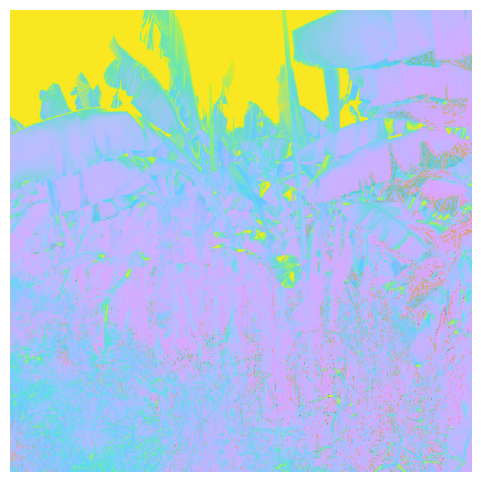

CPU times: user 949 ms, sys: 125 ms, total: 1.07 s
Wall time: 903 ms


In [171]:
%%time

img_tfe = tf.keras.preprocessing.image.load_img(test_img_pth, target_size=(768, 768))
img_tfe = tf.keras.preprocessing.image.img_to_array(img_tfe)

#model.summary()
data = ([img_tfe], None)

class_index = 3
explainer = GradCAM()
# Compute GradCAM on VGG16
grid = explainer.explain(
    data, best_model_reload, class_index=class_index, image_weight=.6)#, layer_name="EfficientNetV2B3") #Existing layers are: ['input_first', 'rescaling', 'EfficientNetV2B3', 'top_output']
explainer.save(grid, ".", "grad_cam_CropLand_carrot.png")


plot_rgb_img_15(grid)

## Model expalin keras.io
* https://keras.io/examples/vision/grad_cam/
* and modify from https://www.kaggle.com/code/ipythonx/tf-hybrid-efficientnet-swin-transformer-gradcam

In [186]:
# The Grad-CAM algorithm
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [189]:
img_path = test_img_pth

model_builder = tf.keras.applications.xception.Xception
preprocess_input = tf.keras.applications.xception.preprocess_input

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=(img_size,img_size)))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

91884032/91884032 [==============================] - 4s 0us/step


ValueError: in user code:

    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "xception" is incompatible with the layer: expected shape=(None, 299, 299, 3), found shape=(None, 768, 768, 3)


## Model explain raw code

`這下面的都無法對tf.hub後的CropLand模型做出CAM`


In [204]:
import cv2
import numpy as np
import tensorflow as tf

# IMAGE_PATH = './0_in.jpg' # 37.jpg, 0_in.jpg, cat.jpg
LAYER_NAME = 'top_output' #'EfficientNetV2B3' #'conv5_block3_out' # vgg16's block5_conv3 -> resnet50's conv5_block3_out

""" imagenet1000_clsidx_to_labels.txt

https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

281: 'tabby, tabby cat',
479: 'car wheel',

"""
CAT_CLASS_INDEX = 0 #281

img = tf.keras.preprocessing.image.load_img(test_img_pth, target_size=(768, 768))
img = tf.keras.preprocessing.image.img_to_array(img)

# model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=True) # .vgg16.VGG16 -> resnet50.ResNet50
model = best_model_reload
# Remove last layer's softmax
model.layers[-1].activation = None


grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.array([img]))
    loss = predictions[:, CAT_CLASS_INDEX]

output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

gate_f = tf.cast(output > 0, 'float32')
gate_r = tf.cast(grads > 0, 'float32')
guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads


#check
print(f'guided_grads {guided_grads.shape} {guided_grads}') # (14,)

weights = tf.reduce_mean(guided_grads,  axis=(0, 1)) # Invalid reduction dimension (1 for input with 1 dimension(s) [Op:Mean]

cam = np.ones(output.shape[0: 2], dtype = np.float32)

for i, w in enumerate(weights):
    cam += w * output[:, :, i]

cam = cv2.resize(cam.numpy(), (768, 768))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 0.5, 0)


#Save CAM image
out_name = 'out_CAM_' + LAYER_NAME + '.png'
cv2.imwrite(out_name, output_image) # OK with RGB format

#Show it now
plt.imshow(output_image)
plt.title(out_name)
plt.show()

#Show it now
import ipyplot
img_org = cv2.imread(IMAGE_PATH)
img_org = cv2.resize(img_org, (768, 768), interpolation=cv2.INTER_CUBIC)
img_org = cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB)
img_cam = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

ipyplot.plot_images([img_org, img_cam],['image', 'mask'], max_images=20, img_width=150)

guided_grads (14,) [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


InvalidArgumentError: {{function_node __wrapped__Mean_device_/job:localhost/replica:0/task:0/device:GPU:0}} Invalid reduction dimension (1 for input with 1 dimension(s) [Op:Mean]

In [127]:
這種重組的functional model需要解出該模型 不然無法使用！！！

SyntaxError: invalid syntax (2414950092.py, line 1)

## tf-keras-vis

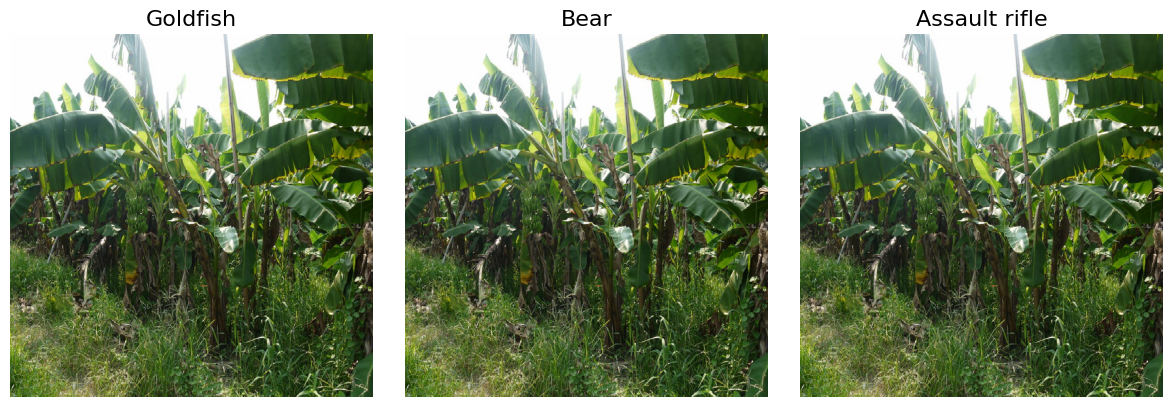

In [193]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input

# Image titles
image_titles = ['Goldfish', 'Bear', 'Assault rifle']

# Load images and Convert them to a Numpy array
img1 = load_img(test_img_pth, target_size=(768, 768))
img2 = load_img(test_img_pth, target_size=(768, 768))
img3 = load_img(test_img_pth, target_size=(768, 768))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])

# Preparing input data for VGG16
X = preprocess_input(images)

# Rendering
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [194]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

# Instead of using the ReplaceToLinear instance above,
# you can also define the function from scratch as follows:
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

In [195]:
from tf_keras_vis.utils.scores import CategoricalScore

# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
score = CategoricalScore([0, 1, 2])

# Instead of using CategoricalScore object,
# you can also define the function from scratch as follows:
def score_function(output):
    # The `output` variable refers to the output of the model,
    # so, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
    return (output[0][1], output[1][294], output[2][413])

In [199]:
model = best_model_reload

In [203]:
%%time

# Vanilla Saliency

from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
# from tf_keras_vis.utils import normalize

# Create Saliency object.
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map
saliency_map = saliency(score, X)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# saliency_map = normalize(saliency_map)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

TypeError: ('Keyword argument not understood:', 'handle')

In [200]:
%%time

from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

# Create GradCAM++ object
gradcam = GradcamPlusPlus(model,
                          model_modifier=replace2linear,
                          clone=True)

# Generate heatmap with GradCAM++
cam = gradcam(score,
              X,
              penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('images/gradcam_plus_plus.png')
plt.show()

TypeError: ('Keyword argument not understood:', 'handle')

In [201]:
%%time

from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.utils import num_of_gpus

# Create ScoreCAM object
scorecam = Scorecam(model)

# Generate heatmap with ScoreCAM
cam = scorecam(score, X, penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

ValueError: Unable to determine penultimate `Conv` layer. `penultimate_layer`=-1

In [202]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
# from tf_keras_vis.utils import normalize

# Create Saliency object.
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map
saliency_map = saliency(score, X)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# saliency_map = normalize(saliency_map)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

TypeError: ('Keyword argument not understood:', 'handle')